In [4]:
import pandas as pd
import numpy as np


def PrepX(X:pd.DataFrame):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    new_cols = []
    for col, t in X_types.items():

        #Leaves numeric columns unchanged, no scaling needed for tree-based methods, scale invariant
        if t in ['int', 'float']: 
            new_cols.append(X[col].copy())
            continue

        #Create dummies for categorical (str) columns
        if t == 'object': 
            new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    return X_prep

#Split data into train and validation set. 
def Split(X:pd.DataFrame, Y:pd.DataFrame, TestSize:float, random_state:int=42):

    split_index = np.random.RandomState(random_state) \
                           .choice([True, False], size=len(Y), p=[TestSize,1-TestSize])
    
    X_test = X[split_index]
    X_train = X[~split_index]
    Y_test = Y[split_index]
    Y_train = Y[~split_index]

    return X_test, X_train, Y_test, Y_train


# Load Data and Prepare for Processesing (PrepX)
with open('../../data/DatasetCleaned.csv', 'r') as f:
    DATA = pd.read_csv(f)

Y_DATA = np.log(DATA['SalePrice'].copy().values)
VAR_DEPENDENT = 'SalePrice'

X_DATA = DATA.copy().drop(columns=['SalePrice','Unnamed: 0'])
X_DATA = PrepX(X_DATA)
VAR_NAMES = X_DATA.columns

#Create Validation Set 
VALIDATION_SET = True
if VALIDATION_SET: 
    X_VAL, X_DATA, Y_VAL, Y_DATA = Split(X_DATA, Y_DATA, 0.05, 1)
    X_VAL = X_VAL.values.reshape(-1, X_VAL.shape[1])

X_DATA = X_DATA.values.reshape(-1,X_DATA.shape[1])

In [ ]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import itertools

#General Parameters for Testing Models
param = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'tree_method':'hist',
    'early_stopping_rounds':5,

    'n_estimators':250,
    'subsample':0.66,

    'verbosity':0,
    'n_jobs':-1,
    'random_state':42
}
#Parameters to be tested; Multiple iterations led to these being the best parameters
grid = {
    'eta':list(np.linspace(0.01,0.3,15)),
    'max_depth':list(range(5,15,3)),
    'colsample_bynode':list(np.linspace(0.5,0.75,3)),
    'reg_alpha':list(np.logspace(-2,-0.5,5))
}
grid_combinations = [dict( zip(grid.keys(), combo) ) for combo in itertools.product(*grid.values())]

#Iterate over all Combination of Testing Parameters
models = []
for test_params in tqdm(grid_combinations, desc='Testing Params'):

    #Fit Model
    xgbModel = xgb.XGBRegressor(**test_params, **param)
    xgbModel.fit(X_DATA, Y_DATA, eval_set=[(X_VAL, Y_VAL)], verbose=False)
    #Rate Model
    rmse = root_mean_squared_error(np.exp(Y_VAL), np.exp(xgbModel.predict(X_VAL)))
    train_r2 = xgbModel.score(X_DATA, Y_DATA)
    test_r2 = xgbModel.score(X_VAL, Y_VAL)
    models.append({'Model':xgbModel,'RSME':rmse,'train_r2':train_r2,'test_r2':test_r2}|test_params)

models = pd.DataFrame(models)

Testing Params:   0%|          | 0/900 [00:00<?, ?it/s]

{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.5), 'reg_alpha': np.float64(0.01)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.5), 'reg_alpha': np.float64(0.023713737056616554)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.5), 'reg_alpha': np.float64(0.05623413251903491)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.5), 'reg_alpha': np.float64(0.1333521432163324)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.5), 'reg_alpha': np.float64(0.31622776601683794)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.625), 'reg_alpha': np.float64(0.01)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.625), 'reg_alpha': np.float64(0.023713737056616554)}
{'eta': np.float64(0.01), 'max_depth': 5, 'colsample_bynode': np.float64(0.625), 'reg_alpha': np.float64(0.05623413251903491)}
{'eta': np.float64(0.01

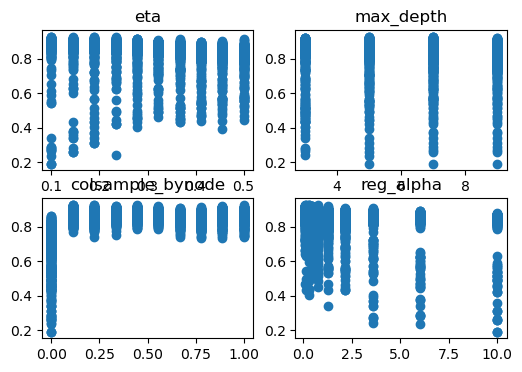

In [ ]:
import matplotlib.pyplot as plt

n_rows = int(np.ceil(len(grid)/2))
fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2*n_rows))
axes = axes.flatten()

for parameter, ax in zip(grid.keys(), axes):
    ax.scatter(models[parameter], models['test_r2'])
    ax.set_title(parameter)

In [1]:
import pickle
import pandas as pd

#MCMC_Tuning is run from CMD to increase efficiency
with open('models/MCMC_XGBoost.sav', 'rb') as f: chains_raw = pickle.load(f)

tuned_parameters = list(chains_raw[0]['samples'][0]['params'].keys()) + ['rsme']
fixed_params = {
            'objective':'reg:squarederror',
            'booster':'gbtree',
            'eval_metric':'rmse',
            'tree_method':'hist',
            'n_estimators':200,
            'verbosity':0,
            'n_jobs':-1,
            'random_state':42
        }
chains = [pd.DataFrame(chain['samples']) for chain in chains_raw]
all_chains = pd.concat(chains, ignore_index=True)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

for i, chain in enumerate(chains):
    best_params = chain.loc[chain['rsme'].idxmin(), 'params']
    best_model = xgb.XGBRegressor(**best_params, **fixed_params).fit(X_DATA, Y_DATA)
    rsme = root_mean_squared_error(np.exp(Y_VAL), np.exp(best_model.predict(X_VAL)))
    print(f'Chain No.{i+1}: {rsme}')

Chain No.1: 16685.97918872777
Chain No.2: 16257.78489285882
Chain No.3: 15517.444809964181
Chain No.4: 15735.21728824353
Chain No.5: 16754.76030161866
Chain No.6: 17521.73546783137
Chain No.7: 17051.432308548938
Chain No.8: 15918.773455469236
Chain No.9: 15512.37181241785
Chain No.10: 17172.66495161629


In [6]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
import xgboost as xgb

def Build_Stacked_Model(X, Y, chains:pd.DataFrame, top_fraction, alphas):

    #Extract top_fraction% of best performing parameters
    top_samples = chains.sort_values(by='rsme').reset_index(drop=True)
    n_top_samples = int(len(top_samples)*top_fraction)
    top_samples = top_samples.iloc[:n_top_samples]

    #Fit best models
    top_models = []
    for model in tqdm(top_samples['params'], total=n_top_samples, desc='Fitting Best Models', unit='Model'):
        top_models.append(xgb.XGBRegressor(**fixed_params, **model).fit(X,Y))

    #Calculating predicted Values for each model
    y_predicted = pd.DataFrame(
        np.column_stack( [model.predict(X) for model in top_models] ),
        columns=[f'Model_{i}' for i in range(len(top_models))]
    )

    Stacked_Model = RidgeCV(alphas=alphas, cv=KFold(), scoring='neg_root_mean_squared_error')
    Stacked_Model.fit(y_predicted, Y_DATA)

    return Stacked_Model, top_models

def Stacked_Model_prepX(X, top_models):

    y_predicted = pd.DataFrame(
        np.column_stack( [model.predict(X) for model in top_models] ),
        columns=[f'Model_{i}' for i in range(len(top_models))]
    )

    return y_predicted

In [7]:
StackedModel, top_models = Build_Stacked_Model(X_DATA, Y_DATA, all_chains, 0.01, np.logspace(-8,0,200))

Fitting Best Models:   0%|          | 0/250 [00:00<?, ?Model/s]

c:\Users\karli\anaconda3\envs\EconML_NumAs\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.67607e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\karli\anaconda3\envs\EconML_NumAs\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.34619e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\karli\anaconda3\envs\EconML_NumAs\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.26896e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\karli\anaconda3\envs\EconML_NumAs\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.12124e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\karli\anaconda3\envs\EconML_NumAs\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=

In [10]:
from sklearn.metrics import root_mean_squared_error

y_pred = StackedModel.predict(Stacked_Model_prepX(X_VAL, top_models))

print(root_mean_squared_error(np.exp(Y_VAL), np.exp(y_pred)))

16680.921044460567


In [ ]:
def test(x):
    return x**2

test.

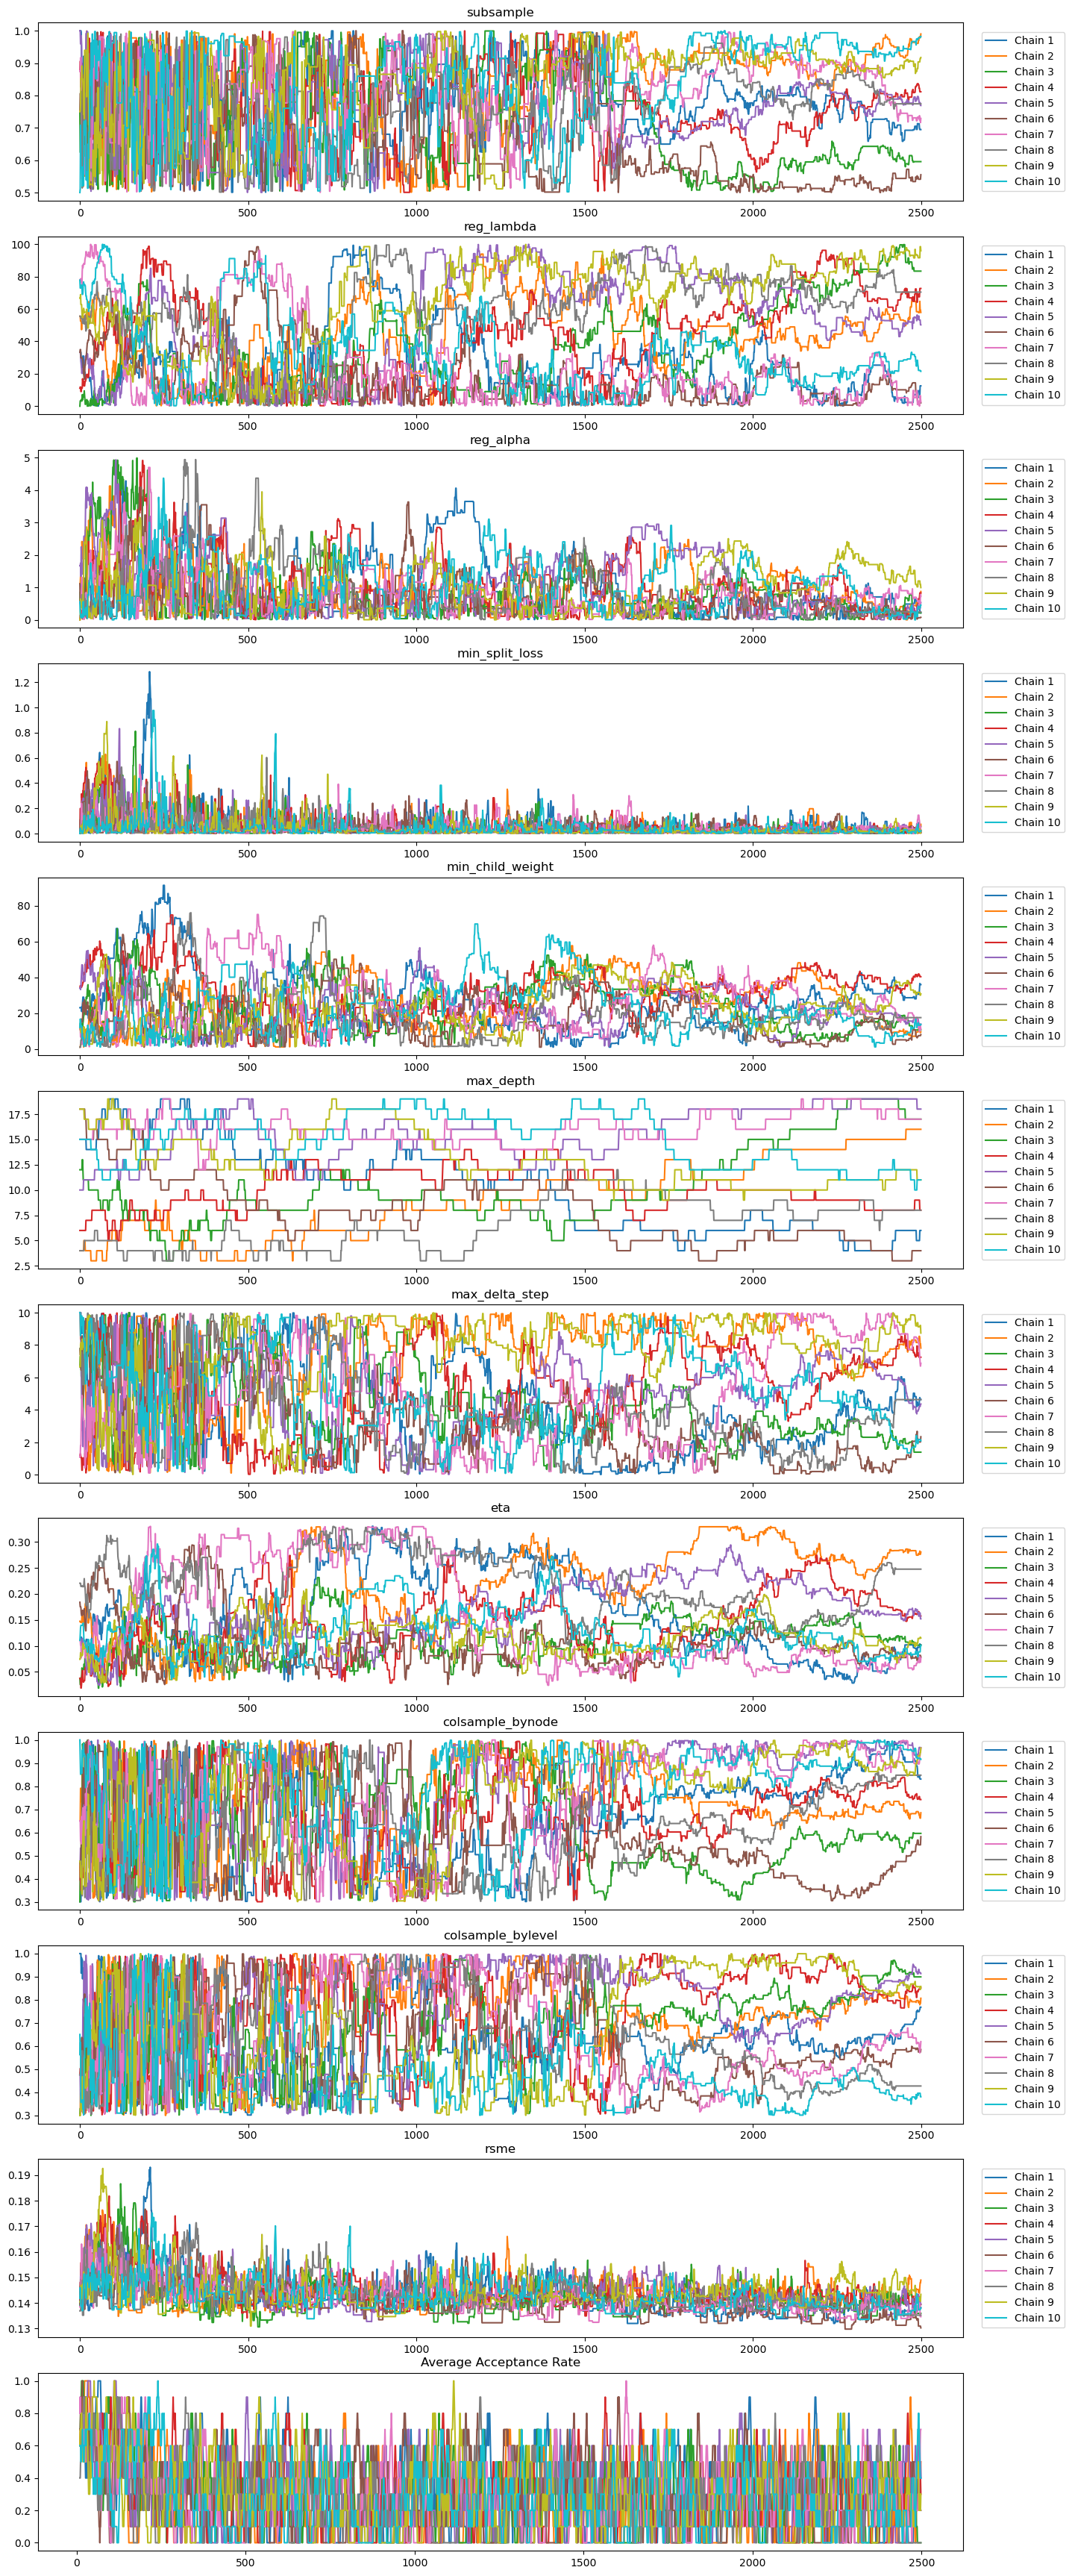

In [3]:
fig, axes = plt.subplots(len(tuned_parameters)+1, 1, figsize=(16,len(tuned_parameters)*4))
axes = axes.flatten()

#Generate Plots for Tuned Parameters and RSME over iterations 
for parameter, ax in zip(tuned_parameters, axes):
    for i, chain in enumerate(chains):
        ax.plot(chain.index, chain[parameter], label=f'Chain {i+1}')
        ax.set_title(parameter)
        ax.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),borderaxespad=0)

#Generate Plot for Acceptance Rate over time
window = 10
for i, chain in enumerate(chains_raw):
    accept_hist = chain['acceptance_history']
    avrg_accept = np.convolve(accept_hist, np.ones(window)/window, mode='valid')
    x_moving = np.arange(window-1,len(accept_hist))
    axes[-1].plot(x_moving, avrg_accept, label=f'Chain {i+1}')
    axes[-1].set_title('Average Acceptance Rate')